In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score as CVS
from sklearn.preprocessing import PolynomialFeatures as PF
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse as RMSE
import scipy.stats as stats
import numbers
import pickle


In [9]:
def transform(data, poly=None, test=False):
    """
    poly values: 'all', 'list', 'singles', 'all_single'
    Note: singles/all_single -column names only have first letters
    
    """
    data_t = data.copy()
    
#     'bathroomsx4', 'bedrooms', 'condition', 'date', 'floorsx2', 'grade', 'lat',
#        'long', 'price', 'sqft_above', 'sqft_basement', 'sqft_living',
#         'sqft_living15', 'sqft_lot', 'sqft_lot15', 'view', 'waterfront',
#         'yr_built', 'yr_renovated', 'zipcode'
    
    to_poly = ['price', 'sqft_above', 'sqft_basement', 'sqft_living',
              'sqft_living15', 'sqft_lot', 'sqft_lot15','yr_built', 
              'yr_renovated',]
    to_log = ['price', 'sqft_above', 'sqft_basement', 'sqft_living',
              'sqft_living15', 'sqft_lot', 'sqft_lot15','yr_built', 
              'yr_renovated',]
    to_norm = ['price', 'sqft_above', 'sqft_basement', 'sqft_living',
              'sqft_living15', 'sqft_lot', 'sqft_lot15','yr_built', 
              'yr_renovated',]
    to_ohe = ['bedrooms', 'bathroomsx4','condition', 'floorsx2','grade','view',]
    poly_order = 2

    if poly in ['all', 'all_single']:
        to_poly = data_t.drop(to_ohe + ['price','date'], axis=1).columns
        if poly == 'all':
            poly = 'list'
        else:
            poly = 'singles'
    if poly == 'list':
        poly=PF(poly_order)
        data_poly = poly.fit_transform(data_t[to_poly])
        data_poly = pd.DataFrame(data_poly)
        data_poly.columns = poly.get_feature_names(data_t[to_poly].columns)
        data_t = pd.concat([data_t.drop(to_poly, axis=1),data_poly.drop('1',axis=1)], axis=1)
    elif poly == 'singles':
        for feat in to_poly:
            df = pd.DataFrame(data_t[feat])
            poly=PF(poly_order)
            data_poly = poly.fit_transform(df)
            data_poly = pd.DataFrame(data_poly)
            data_poly.columns = ['drop', feat, feat + '_squared']
            data_t = pd.concat([data_t.drop(feat, axis=1), 
                                data_poly.drop('drop',axis=1)], axis=1)

    for feat in to_log:
        data_t[feat] = data_t[feat].map(lambda x: np.log(x) if x!=0 else 0)
        #Note 'if' included so that 0 values wouldn't error, will still error
        #...between 0 and 1. Also, implies that the original 0 value was a 1
        #...but as these are around values of 100s, 1000s, the effect is minimal

        
    stats = {}
    if test:
        with open('norm_stats.pickle', 'rb') as f:
            stats = pickle.load(f)
    for feat in to_norm:
        ft = data_t[feat]
        if test:
            mean = stats[feat][0]
            stdev = stats[feat][1]
        else:
            mean = np.mean(ft)
            stdev = np.sqrt(np.var(ft))
        data_t[feat] = (ft-mean) / stdev
        stats[feat] = [mean, stdev]
    with open('norm_stats.pickle', 'wb') as f:
        pickle.dump(stats, f)
        
        
    for feat in to_ohe:
        
        dummies = pd.get_dummies(data=data_t[feat], prefix=feat, prefix_sep='_',
                                drop_first=True)
        data_t.drop(feat, axis=1, inplace=True)
        data_t = pd.concat([data_t, dummies], axis=1)
    
    return data_t 

#Note data_t = data.copy()   --line added as otherwise the DataFrame, data, 
#...outside of this function lost the first column mentioned in [to_ohe]

In [21]:
def simple_selector(data_s, x_cols, alpha=0.05):

    predictors = '+'.join(x_cols)
    f = 'price' + '~' + predictors
    results = ols(formula=f, data=data_s).fit()
    pv = pd.DataFrame(results.pvalues).drop('Intercept')
    pv.rename(columns={0:'p_value'}, inplace=True)
    x_cols = list(pv[pv.p_value <= alpha].index)
    
    return x_cols, pv

In [22]:
def stepwise_selector(data_s, 
                       x_cols=[], 
                       alpha=0.05, 
                       verbose=False):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        x_cols - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    
    X = data_s[x_cols]
    y = data_s['price']
    threshold_in = alpha - 0.02
    threshold_out = alpha + 0.01
    included = list(x_cols)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            results = sm.OLS(y, sm.add_constant
                             (pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = results.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        results = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = results.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, 
                                                             worst_pval))
        if not changed:
            break
            
    pv = pd.DataFrame(results.pvalues)
    pv.rename(columns={0:'p_value'}, inplace=True)
    return included, pv

## Multicollinearity Function: Remove    
The first multicollinearity function removes a feature from each pair with high multicollinearity    
This function takes in thedata, x_cols and the threshold for removing a feature

- create a dataframe of the correlation of the features in x_cols   
- transform this to get a list of pairs of features with high multicollinearity
- for each pair: check whether they are the same feature or if one of the features has already been listed to be removed; if so, continue to next pair 
- otherwise add the feature with the higher p-value to a list    
- remove the features in this list from x_cols    


return x_cols     




In [8]:
def multicoll_remove(data, x_cols, pvalues, multicollinearity_threshold):
    corr = data[x_cols].corr().abs().stack().reset_index().sort_values(0,
                                                            ascending = False)
    corr['pairs'] = list(zip(corr.level_0, corr.level_1))
    corr = corr.set_index('pairs').drop(['level_0', 'level_1'], axis=1)
    corr.columns = ['cc']
    corr = corr[corr.cc > multicollinearity_threshold]        

    to_drop = []
    for f0, f1 in corr.index:
        if (f0 == f1) | any(feat in [f0, f1] for feat in to_drop):
            continue
        to_drop.append(pvalues.loc[[f0, f1]].sort_values('p_value', 
                                                ascending=False).index[0])
    x_cols = list(set(x_cols) - set(to_drop))
    return x_cols   

In [10]:
def metrics(data, results, x_cols):
    X = data[x_cols]
    y = data.price
#     to_pred = pd.concat([y,X], axis=1)
#     yhat = results.predict(to_pred)
#     rmse = RMSE(y, yhat)
    
    linreg = LR()
    linreg.fit(X,y)
    cv  = np.mean(CVS(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
    rmse = (-cv)**0.5
      
#     print(f'RMSE: {rmse}')
    
    fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45',
                             fit=True, alpha=0.1)

    fig = plt.figure(figsize=(12,12))
    plt.scatter(data.price, results.resid, alpha=0.5);
    plt.hlines(0, xmax=data.price.max(), xmin=data.price.min());    

## Modelling Function
Takes in the dataframe and optional transform and multicollinearity arguments    
Checks whether to send the data to a transform function   
Selects for x_cols the features from data that are numeric, and not the price   
##### Loop

**1. Remove features with high p-values:**  
- creates the formula using x_cols     
- creates the model using formula   
- creates a dataframe, pv, of the model's p-values  
- creates a new x_cols list from the features in pv with low p-values   

**2. Handle multicollinearity:**     
- Checks whether a function has been passed for handling multicollinearity and calls accordingly    
    
         
            
            
Checks whether the length of x_cols has changed. Loop runs again if it has.     
    
    
When x_cols no longer changes, the final model and x_cols are returned





In [11]:
def modelling(datam, selector=simple_selector, transform=None, multicoll=None, 
              alpha=0.05, 
              multicollinearity_threshold = 0.7):
    
    if transform:
        datam = transform(datam)
        
    outcome = 'price'
    x_cols = [col for col in (datam.drop([outcome], axis=1).columns) 
            if isinstance(datam[col][0], numbers.Number)]
    i = 0
    while True:
        length0 = len(x_cols)
        print(f'Loop:{i}\nNumber of features: {length0}')
        
        x_cols, pvalues = selector(datam, x_cols, alpha)
        length1 = length0-len(x_cols)
        print(f'Removed by Selector: {length1}')
        
        if not i and multicoll:
            x_cols = multicoll(datam, x_cols, pvalues, 
                                      multicollinearity_threshold)
            length2 = length0 - length1 - len(x_cols)
            print(f'Removed for multicollinearity: {length2}')
        
        
        i+=1
        if len(x_cols) == length0:
            break
        
    predictors = '+'.join(x_cols)
    f = 'price' + '~' + predictors
    results = ols(formula=f, data=datam).fit()

    metrics(datam, results, x_cols)
    
    return results, x_cols

#  Model

Initial model using only cleaned data:

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     1071.
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:47:03   Log-Likelihood:                -11735.
No. Observations:               16987   AIC:                         2.358e+04
Df Residuals:                   16934   BIC:                         2.399e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.8984      7.927     -0.239      0.811     -17.436      13.639
bathroomsx4_22     1.2132      0.193      6.279      0.000       0.834       1.592
bathroomsx4_24     1.6797      0.224      7.512      0.000       1.241       2.118
floorsx2_4         0.1564      0.013     12.500      0.000       0.132       0.181
yr_built          -0.2187      0.006    -36.790      0.000      -0.230      -0.207
bedrooms_5         0.0598      0.016      3.802      0.000       0.029       0.091
bathroomsx4_6      0.0678      0.018      3.811      0.000       0.033       0.103
bathroomsx4_8      0.2152      0.016     13.061      0.000       0.183       0.247
grade_12           1.0550      0.067     15.853      0.000       0.925       1.185
condition_4        0.1047      0.009     11.081      0.000       0.086       0.123
grade_7           -0.8105      0.016    -52.185      0.000      -0.841      -0.780
sqft_lot15        -0.0428      0.005     -8.986      0.000      -0.052      -0.033
zipcode           -0.0012   8.24e-05    -15.061      0.000      -0.001      -0.001
grade_8           -0.4485      0.014    -32.579      0.000      -0.475      -0.421
view_2             0.2436      0.018     13.208      0.000       0.207       0.280
bathroomsx4_19     1.1555      0.128      9.016      0.000       0.904       1.407
bathroomsx4_20     1.0193      0.124      8.220      0.000       0.776       1.262
view_4             0.5095      0.039     12.953      0.000       0.432       0.587
grade_4           -1.9121      0.105    -18.197      0.000      -2.118      -1.706
bathroomsx4_7      0.1639      0.015     10.994      0.000       0.135       0.193
bathroomsx4_21     1.1105      0.137      8.111      0.000       0.842       1.379
bathroomsx4_18     0.7410      0.060     12.344      0.000       0.623       0.859
grade_5           -1.4968      0.040    -37.359      0.000      -1.575      -1.418
bathroomsx4_31     2.1078      0.519      4.058      0.000       1.090       3.126
grade_13           1.6467      0.185      8.925      0.000       1.285       2.008
bathroomsx4_9      0.2104      0.019     11.296      0.000       0.174       0.247
bathroomsx4_23     0.8168      0.288      2.836      0.005       0.252       1.381
floorsx2_5         0.2568      0.047      5.432      0.000       0.164       0.350
sqft_living15      0.2033      0.006     33.474      0.000       0.191       0.215
bedrooms_4         0.0455      0.009      4.983      0.000       0.028       0.063
sqft_basement      0.0612      0.005     13.213      0.000       0.052       0.070
floorsx2_6         0.2265      0.027      8.238      0.000       0.173       0.280
bathroomsx4_14     0.5502      0.028     19.471      0.000       0.495       0.606
floorsx2_3         0.1470      0.015      9.930      0.000       0.118       0.176
grade_11    

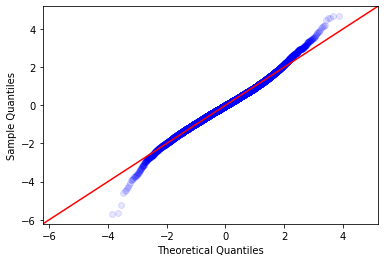

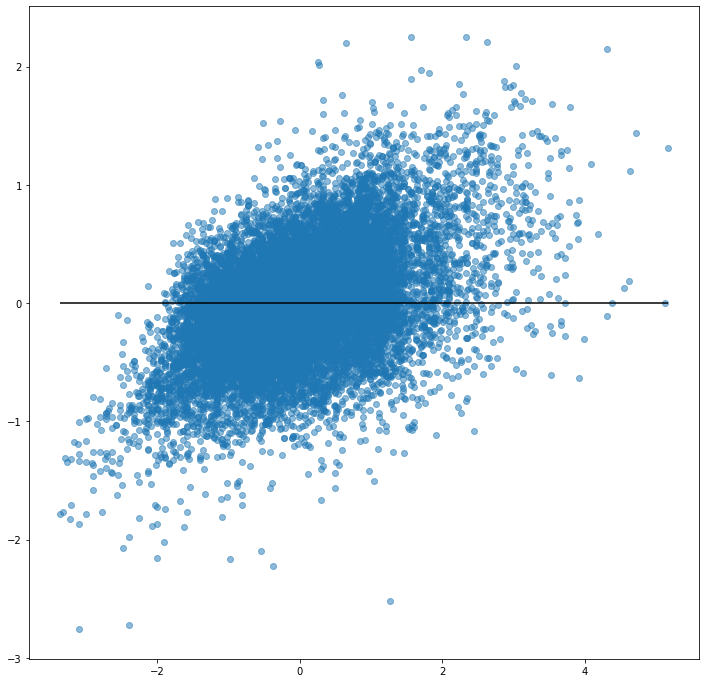

In [27]:
data = pd.read_csv('data/clean.csv')
data.date = pd.to_datetime(data.date)
data.sort_index(axis=1, inplace=True)
data_train, data_test = tts(data, train_size=0.8, random_state=111)
multicollinearity_threshold=0.7

data_t = transform(data_train)

outcome = 'price'
x_cols = [col for col in (data_t.drop([outcome], axis=1).columns) 
                    if isinstance(data_t[col][0], numbers.Number)]

x_cols, pvalues = stepwise_selector(data_t, x_cols)

x_cols = multicoll_remove(data_t, x_cols, pvalues, multicollinearity_threshold)
x_cols, pvalues = stepwise_selector(data_t, x_cols)

predictors = '+'.join(x_cols)
f = 'price' + '~' + predictors
results = ols(formula=f, data=data_t).fit()

metrics(data_t, results, x_cols)
results.summary()

